# Set - up 

In [52]:
#Imports
import pymysql
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from gensim.sklearn_api.atmodel import AuthorTopicTransformer
from sklearn.metrics import silhouette_score, silhouette_samples
from gensim.corpora import Dictionary
from sklearn.cluster import KMeans
import seaborn as sns
from gensim.models import AuthorTopicModel
from sklearn.decomposition import PCA

# Importing the data

### Get basket data 

In [2]:
# Load the data for products inside baskets
baskets_df = pd.read_csv('baskets.csv', index_col='basket_id')

In [3]:
baskets_df.shape

(187188, 121)

### Get the customers data 

In [4]:
# Load the customer-to-basket map
customers_df = pd.read_csv('customers.csv')

In [5]:
customers_df.shape

(187188, 2)

# Author-Topic Modeling 

###  Prepare the data for the model

In [6]:
baskets_df.head()

,CL00001,CL00002,CL00003,CL00006,CL00007,CL00008,CL00010,CL00013,CL00014,CL00015,...,CL00205,CL00207,CL00209,CL00212,CL00214,CL00218,CL00219,CL00222,CL00229,CL00235
basket_id,,,,,,,,,,,,,,,,,,,,,
994100100153442,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
994100100153740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
994100100154465,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
994100100155062,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
994100100155064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In order to apply gensim's `atmodel`, we need to convert our `baskets_df` frequency dataframe to a list of lists containing the products per basket. Here, we are going to use the name of each product as many times as it appears in a basket. 

In [8]:
# Create the list
corpus_list = []

#Iterate over all the rows to create the list of products (basket)
for pos, row in enumerate(baskets_df.iterrows()):
    # Create a list with all the tokens (products) for each basket
    corpus_list.append([col for col in baskets_df.columns \
                        for x in range(baskets_df.loc[row[0], col])])
    
    #Status flag just to know the status of the process
    if pos % 50000 == 0:
        print(round(pos/(baskets_df.shape[0]-1),2))

0.0
0.27
0.53
0.8


This process could be further optimized since the `iterrows()` is known to be quite slow for large datasets, however, meets our current needs. This is a future improvement.

In [9]:
# Create dictionary object with this corpus list, which is required by the ATM model
dictionary = Dictionary(corpus_list)

This dictionary maps every single toke (product) of our dataset to an ID for building the bag-of-words representation in the next step. 

In [13]:
# Translate the corpus into a bag of words format (required by gensim)
corpus = [dictionary.doc2bow(doc) for doc in corpus_list]

In [15]:
#Check the format
corpus[1]

[(1, 1),
 (3, 1),
 (4, 1),
 (6, 1),
 (9, 1),
 (12, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 2),
 (23, 1),
 (24, 2),
 (25, 1)]

This is the second basket that contains multiple products with different IDs and here the product count is added. Now, the model requires a map to all the baskets purchased by each customer using the index (orden of appearance for each basket in the corpus).  

In [18]:
# Add an index to the baskets using the trim_row_counts dataframe
baskets_map = baskets_df.reset_index()['basket_id'].reset_index()

In [20]:
# Append the index to the customers_df data (to add the index to the basket_id)
customers_df = customers_df.merge(baskets_map, on='basket_id')

Now we will loop through the customers and store the customer to basket index map to feed the ATM model. This lets the model know which customer bought each of the baskets by assigning the index of the basket to the customer.


In [21]:
#Create map
customers_map = {}

#Loop over customers
for cust in customers_df.cust_id.unique():
        customers_map[cust] = customers_df.loc[customers_df.cust_id==cust,'index'].to_list()

In [24]:
#Let's take a look at an example
customers_map['CUST0000000013']

[86241, 94491, 106053, 125466, 130163, 131778, 148733, 150252]

Customer `CUST0000000013` bought all the baskets with the index shown before. 

In [26]:
# Get a summary of the data to feed the model
print('Number of authors: %d' % len(customers_map))
print('Number of unique tokens: %d' % len(dictionary))
print('Number of baskets: %d' % len(corpus))

Number of authors: 4522
Number of unique tokens: 121
Number of baskets: 187188


### Apply ATM with  5, 10, 20 and 30 topics and evaluate 

In [36]:
#Define the number of topics
no_topics = [10, 20, 30]

In [42]:
%%time
#Store models
models = []

for num in no_topics:
    idx=0
    model_dict = {}
    # Fit the model
    model_dict['model'] = AuthorTopicModel(corpus=corpus, num_topics=num, author2doc=customers_map, random_state=42)
    
    # Get the probability of topics for each customer
    customer_topics = [model_dict['model'].get_author_topics(author) for author in customers_df.cust_id.unique()]
    
    #Map customer topics into dataframe
    for i in range(len(customer_topics)):
        if i==0:
            customer_topics_df = pd.DataFrame(customer_topics[i]).set_index(0).T
        else:
            customer_topics_df = customer_topics_df.append(pd.DataFrame(customer_topics[i]).set_index(0).T)

    # Fill NAs with zero
    customer_topics_df.fillna(0, inplace=True)        
            
    #Save to dict
    model_dict['topics_df'] = customer_topics_df
    
    # Append model dictionary to list
    models.append(model_dict)
    print(f'Model with {no_topics[idx]} topics appended...')
    idx+=1

Model with 10 topics appended...
Model with 10 topics appended...
Model with 10 topics appended...
Wall time: 28min 4s


Now we are going to evaluate the model for topic coherence using the `top_topics` method and picking the model with the highest coherence as given by gensim. 

In [45]:
%%time
model_list = [mod['model'] for mod in models]
model_scores = []

for model in model_list:
    #Get the top topics
    top_topics = model.top_topics(corpus=corpus, dictionary=dictionary)
    # Get the topic coherence for the top topics and sum 
    tc = sum([t[1] for t in top_topics])
    # Append 
    model_scores.append(tc)

Wall time: 13.3 s


In [47]:
# Choose the model with highest coherence
top_index = np.argmax(model_scores)
print('Topic coherence: %.3e' %model_scores[top_index])

Topic coherence: -1.880e+01


Now that we have chosen our best mode, we can store it for later use if needed in order to preserve reproducibility. 

In [49]:
#Best model
top_index

0

In [50]:
# Save model.
model_list[top_index].save('model.atmodel')

In [51]:
# Load model.
model = AuthorTopicModel.load('model.atmodel')

### Random initializations for 5 topics 

In [61]:
## TBD

### KMeans for 5 topics 

In [53]:
km_models = []
for no_clus in range(2,20):
    # Fit the model
    km_models.append(KMeans(n_clusters=no_clus,
                           random_state=1).fit(models[top_index]['topics_df']))

In [56]:
scores = [silhouette_score(models[top_index]['topics_df'], mod.labels_) for mod in km_models]

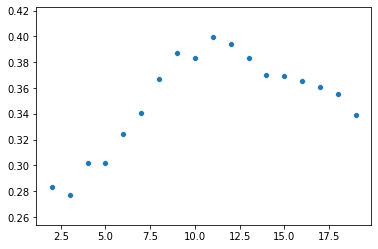

In [57]:
sns.scatterplot(x=range(2,20), y=scores)

In [58]:
inertias = [mod.inertia_ for mod in km_models]

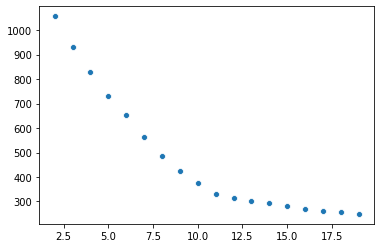

In [59]:
sns.scatterplot(x=range(2,20), y=inertias)

In [60]:
# Get the silhouette score for the best model
best_score_idx = np.argmax(scores)
silhouette_score(models[top_index]['topics_df'], km_models[best_score_idx].labels_)

0.39966307665903034

### Visualizing our clusters 

In [63]:
# PCA to extract 2 main components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(models[top_index]['topics_df'])

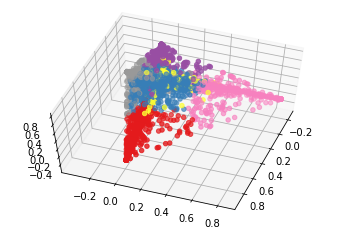

In [65]:
from mpl_toolkits import mplot3d

ax1 = plt.axes(projection='3d')
ax1.view_init(60, 20)
# Data for three-dimensional scattered points
ax1.scatter3D(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=km_models[4].labels_, cmap='Set1');

### Making sense of the clusters using customer data 

Although we can't use the product data to find out what customers buy, we can use the customer data to explore characteristics of this customers. 

In [538]:
#Query products grouped by basket_id and prod_code_10
customers_data = pd.read_sql('select Customers.cust_id,\
                             sum(Transactions.spend) as total_spend,\
                             sum(Transactions.quantity) as total_quantity,\
                             count(distinct Transactions.basket_id) as no_transactions,\
                             Customers.cust_lifestage,\
                             Customers.cust_price_sensitivity\
                             from Customers \
                             inner join Transactions on Customers.cust_id = Transactions.cust_id\
                             group by Customers.cust_id;', conn)

In [539]:
customers_data.set_index('cust_id', inplace=True)
customers_data.head()

,total_spend,total_quantity,no_transactions,cust_lifestage,cust_price_sensitivity
cust_id,,,,,
CUST0000000013,160.32,122.0,12,YF,MM
CUST0000000055,433.65,320.0,15,YA,LA
CUST0000000679,85.63,78.0,14,OT,MM
CUST0000001052,260.92,98.0,31,PE,UM
CUST0000001058,71.50,46.0,2,OT,UM


In [540]:
#Subset data to only customers we have
customers_data = customers_data.loc[customers_df.cust_id.unique(),:]

### How about spend, lifestage and shopping activity 

In [542]:
# Add the tags
customers_data['atm_tag'] = km_models[4].labels_

In [543]:
# Get counts
customers_data.atm_tag.value_counts(normalize=True)

1    0.380291
0    0.149030
2    0.137125
4    0.119709
3    0.117945
5    0.095899
Name: atm_tag, dtype: float64

In [544]:
#ANalyze no_transactions
customers_data.groupby('atm_tag')['no_transactions'].sum()

atm_tag
0    90314
1    57467
2    73553
3    65759
4    59042
5    42486
Name: no_transactions, dtype: int64

In [545]:
customers_data.groupby('atm_tag')['total_spend'].sum()/customers_data.groupby('atm_tag')['no_transactions'].sum()

atm_tag
0    12.573747
1    13.026350
2    12.086101
3    11.844981
4    12.814692
5    12.211617
dtype: float64

In [536]:
#ANalyze spend
customers_data.groupby('atm_tag')['total_spend'].sum()

atm_tag
0    1135585.40
1     748585.24
2     888968.96
3     778914.13
4     756605.06
5     518822.76
Name: total_spend, dtype: float64

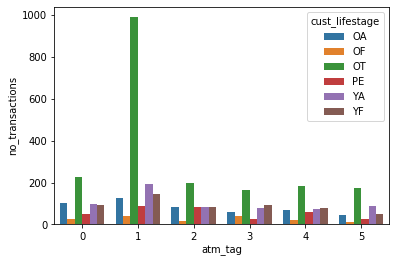

In [511]:
#Analyze customer segments

ls_by_segment = customers_data.groupby(['atm_tag', 'cust_lifestage'])['no_transactions'].count().reset_index()

sns.barplot(x='atm_tag', y='no_transactions', hue='cust_lifestage', 
            data=ls_by_segment)

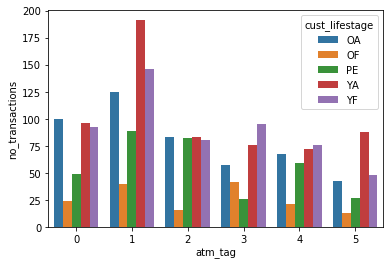

In [510]:
#Analyze customer segments (exluding other)

sns.barplot(x='atm_tag', y='no_transactions', hue='cust_lifestage', 
            data=ls_by_segment[ls_by_segment.cust_lifestage != 'OT'])

In [515]:
ls_by_segment.pivot_table(index='atm_tag', columns='cust_lifestage')

no_transactions                       
cust_lifestage              OA  OF   OT  PE   YA   YF
atm_tag                                              
0                          100  24  225  49   96   93
1                          125  40  990  89  191  146
2                           83  16  198  82   83   81
3                           58  42  163  26   76   95
4                           68  22  183  59   72   76
5                           43  13  175  27   88   48